In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Make dummy test spectrum

In [104]:
# binning in logspace
wvl = np.logspace(np.log10(4000), np.log10(7000), 13)
flux = np.ones(len(wvl))

Text(0, 0.5, 'Flux')

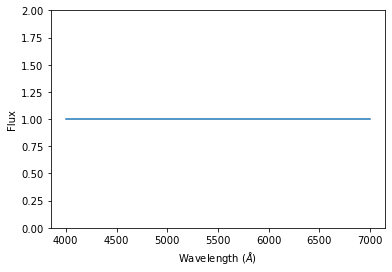

In [105]:
plt.plot(wvl, flux)

plt.ylim((0,2))
plt.xlabel('Wavelength $(\AA)$')
plt.ylabel('Flux')

# Define Useful Functions:

In [88]:
def bin_centers_to_edges(centers):
    """Converts bin centers to bin edges. Assumes bins are logspaced."""
    log_centers = np.log10(centers)
    bin_rad = np.diff(log_centers)[0]/2.0
    edges = [center - bin_rad for center in log_centers]
    edges.append(log_centers[-1] + bin_rad)
    return np.power(10, np.array(edges))

def bin_edges_to_centers(edges):
    """Converts bin edges to centers. Assumes bins are logspaced."""
    log_edges = np.log10(edges)
    bin_rad = np.diff(log_edges)[0] / 2.0
    centers = log_edges[:-1] + bin_rad
    return np.power(10, centers)
    
print('Show edges and centers have same log spacing:')
print(np.diff(np.log10(wvl)))
print(np.diff(np.log10(bin_centers_to_edges(wvl))))

print('Show center to edges and edges to center cancel out:')
print(bin_edges_to_centers(bin_centers_to_edges(wvl)) - wvl)

Show edges and centers have same log spacing:
[0.02025317 0.02025317 0.02025317 0.02025317 0.02025317 0.02025317
 0.02025317 0.02025317 0.02025317 0.02025317 0.02025317 0.02025317]
[0.02025317 0.02025317 0.02025317 0.02025317 0.02025317 0.02025317
 0.02025317 0.02025317 0.02025317 0.02025317 0.02025317 0.02025317
 0.02025317]
Show center to edges and edges to center cancel out:
[0.00000000e+00 4.54747351e-12 4.54747351e-12 0.00000000e+00
 4.54747351e-12 5.45696821e-12 0.00000000e+00 6.36646291e-12
 5.45696821e-12 0.00000000e+00 7.27595761e-12 7.27595761e-12
 0.00000000e+00]


In [89]:
def rebin_resolution(wvl, resolution_factor):
    """
    Parameters
    ----------
    wvl : np.ndarray
        Original logspaced bin edges.
    resolution_factor : float
        Factor to reduce original resolution by.
        
    Returns
    -------
    new_wvl : np.ndarray
        New logspaced bin edges.
    """
    orig_wvl_start = wvl[0]
    orig_wvl_end = wvl[-1]
    orig_bin_rad = np.diff(np.log10(wvl))[0] / 2.0
    new_bin_rad = resolution_factor * orig_bin_rad
    new_bins = np.arange(np.log10(orig_wvl_start), np.log10(orig_wvl_end), 2*new_bin_rad)
    return np.power(10, new_bins)

wvl_edges = bin_centers_to_edges(wvl)
new_wvl_edges = rebin_resolution(wvl_edges, 2.5)
old_logbin_width = np.diff(np.log10(wvl_edges))[0]
new_logbin_width = np.diff(np.log10(new_wvl_edges))[0]
print('Old logbin width = %f'%(old_logbin_width))
print('New logbin width = %f'%(new_logbin_width))
print('New/Old width ratio = %f'%(new_logbin_width / old_logbin_width))

Old logbin width = 0.020253
New logbin width = 0.050633
New/Old width ratio = 2.500000


[0.  0.  0.  0.7 1.  1.  0.6 0.  0.  0.  0.  0.  0. ]


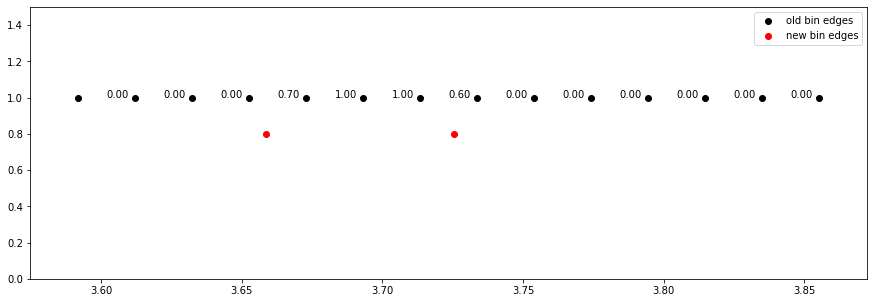

In [102]:
def new_bin_old_bin_overlap(new_center, new_bin_rad, old_edges):
    """
    Parameters
    ----------
    new_center : float
        Center of new bin.
    new_bin_rad : float
        Radius of new bin in logspace.
    old_edges : np.ndarray
        Original bin edges.
        
    Returns
    -------
    overlap : np.ndarray
        Fractional overlap of old bins inside new bin.
    """
    new_log_center = np.log10(new_center)
    old_log_edges = np.log10(old_edges)
    old_logbin_width = np.diff(old_log_edges)[0]
    new_left_edge = new_log_center - new_bin_rad
    new_right_edge = new_log_center + new_bin_rad
    
    left_ind_in_old_bins = np.searchsorted(old_log_edges, new_left_edge, side='right')
    right_ind_in_old_bins = np.searchsorted(old_log_edges, new_right_edge, side='left')
    
    overlap = np.zeros(len(old_edges) - 1)
    
    left_overlap = (old_log_edges[left_ind_in_old_bins] - new_left_edge) / old_logbin_width
    right_overlap = (new_right_edge - old_log_edges[right_ind_in_old_bins - 1]) / old_logbin_width
    
    overlap[left_ind_in_old_bins - 1] = left_overlap
    overlap[right_ind_in_old_bins - 1] = right_overlap
    overlap[left_ind_in_old_bins : right_ind_in_old_bins - 1] = 1.0
    return overlap

wvl_edges = bin_centers_to_edges(wvl)
new_wvl_edges = rebin_resolution(wvl_edges, 3.3)
new_wvl_centers = bin_edges_to_centers(new_wvl_edges)
new_bin_rad = np.diff(np.log10(new_wvl_centers))[0] / 2.0

new_center = new_wvl_centers[1]
overlap = new_bin_old_bin_overlap(new_center, new_bin_rad, wvl_edges)
plt.figure(figsize=(15,5))
plt.scatter(np.log10(wvl_edges), np.ones(len(wvl_edges)), label='old bin edges', c='k')
plt.scatter([np.log10(new_center) - new_bin_rad, np.log10(new_center) + new_bin_rad], [0.8,0.8], label='new bin edges', c='r')
for i in range(len(overlap)):
    plt.text(np.log10(wvl[i]), 1, '%.2f'%(overlap[i]))
plt.ylim((0,1.5))
plt.legend()
print(overlap)

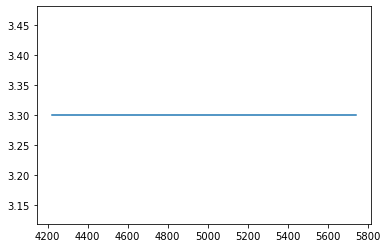

In [103]:
def rebin_fluxes(old_fluxes, old_wvl_centers, new_wvl_centers):
    """
    Parameters
    ----------
    old_fluxes : np.ndarray
        Old fluxes.
    old_wvl_centers : np.ndarray
        Old wvl centers.
    new_wvl_centers : np.ndarray
        New wvl centers.
        
    Returns
    -------
    new_fluxes : np.ndarray
        New fluxes.
    """
    
    overlap_matrix = np.ndarray((len(new_wvl_centers), len(old_wvl_centers)))
    old_wvl_edges = bin_centers_to_edges(old_wvl_centers)
    new_bin_rad = np.diff(np.log10(new_wvl_centers))[0] / 2.0
    
    for i in range(len(new_wvl_centers)):
        bin_center = new_wvl_centers[i]
        overlap_arr = new_bin_old_bin_overlap(bin_center, new_bin_rad, old_wvl_edges)
        overlap_matrix[i,:] = overlap_arr
        
    return np.matmul(overlap_matrix, old_fluxes)


wvl_edges = bin_centers_to_edges(wvl)
new_wvl_edges = rebin_resolution(wvl_edges, 3.3)
new_wvl_centers = bin_edges_to_centers(new_wvl_edges)
new_fluxes = rebin_fluxes(flux, wvl, new_wvl_centers)
plt.plot(new_wvl_centers, new_fluxes)